In [1]:
# récupération des données stocker : X et Y (Stored X)
X = None
Y = None
%store -r X
%store -r Y

## Analyse des données

In [2]:
# Importation des librairies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
X

,Date_inspection,APP_Libelle_activite_etablissement,latitude,longitude
0,1.682381e+09,0,49985274.0,1561386.0
1,1.677110e+09,0,4615861.0,6677963.0
2,1.664842e+09,1,48881317.0,223746.0
4,1.678234e+09,1,48844091.0,2219818.0
5,1.682381e+09,1,48072687.0,4185142.0
...,...,...,...,...
32715,1.680134e+09,29,21206368.0,55337063.0
32716,1.669248e+09,0,48873997.0,2341843.0
32717,1.681690e+09,21,44078462.0,5999322.0
32718,1.686874e+09,0,45738402.0,4837636.0


In [4]:
Y

0             Satisfaisant
1             Satisfaisant
2             Satisfaisant
4              A améliorer
5        Très satisfaisant
               ...        
32715         Satisfaisant
32716         Satisfaisant
32717         Satisfaisant
32718         Satisfaisant
32719         Satisfaisant
Name: Synthese_eval_sanit, Length: 31961, dtype: object

## Séparation des données en données d'entrainement et de test

In [5]:
len(X), len(Y)

(31961, 31961)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2)
len(X_train), len(X_valid), len(y_train), len(y_valid)

(25568, 6393, 25568, 6393)

In [7]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)

In [8]:
X_train.shape, y_train_encoded.shape, X_valid.shape, y_valid_encoded.shape

((25568, 4), (25568,), (6393, 4), (6393,))

## Entrainement sur plusieurs modèle de classification

In [9]:
# Importation des librairies de classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [10]:
models = {
    "KNN": KNeighborsClassifier(n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gaussian NB": GaussianNB(),
    "MLP Classifier": MLPClassifier(max_iter=1000),
    "SGD": SGDClassifier(),
}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    # Random seed for reproducible results
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

model_scores = fit_and_score(models, X_train, X_valid, y_train_encoded, y_valid_encoded)

for model, score in model_scores.items():
    print(f"{model}: {score}")

KNN: 0.55764117002972
Random Forest: 0.6280306585327702
Gradient Boosting: 0.6136399186610355
AdaBoost: 0.5771938057250118
Gaussian NB: 0.5288596902862506
MLP Classifier: 0.5390270608478023
SGD: 0.058501486000312845


## Affichage des résultats

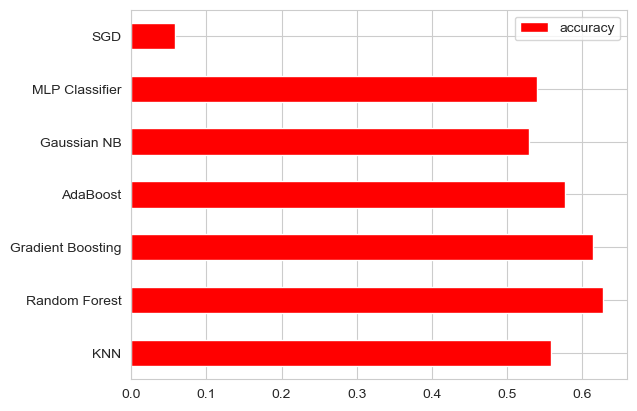

In [11]:
# Affichage des résultats
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.barh(color='red');

## Optimisation des modèles

In [12]:
# Importation des librairies
from sklearn.model_selection import RandomizedSearchCV

In [13]:
# Optimisation du model RandomForest avec les meilleurs paramètres
rf_params = {
    'n_estimators': np.arange(10, 1000, 50),
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 20, 2),
    'max_features': [0.5, 1, 'sqrt', 'auto'],
    'max_samples': [10000]
}

# Instanciation du modèle
rs_rf = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1),
                                   param_distributions=rf_params,
                                   n_iter=20,
                                   cv=5,
                                   verbose=True)

# Entrainement du modèle
rs_rf.fit(X_train, y_train_encoded)

# Affichage des meilleurs paramètres
rs_rf.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'n_estimators': 810,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [14]:
# Creation des meilleurs paramètres
ideal_model_rf = RandomForestClassifier(n_estimators=260,
                                         min_samples_split=18,
                                         min_samples_leaf=1,
                                         max_samples=10000,
                                         max_features='sqrt',
                                         max_depth=None,
                                         n_jobs=-1,
                                         random_state=42)
ideal_model_rf.fit(X_train, y_train_encoded)
train_score = ideal_model_rf.score(X_train, y_train_encoded)
valid_score = ideal_model_rf.score(X_valid, y_valid_encoded)

print("Précision sur l'ensemble d'entraînement : {:.2f}%".format(train_score * 100))
print("Précision sur l'ensemble de validation : {:.2f}%".format(valid_score * 100))

Précision sur l'ensemble d'entraînement : 74.39%
Précision sur l'ensemble de validation : 64.27%


In [15]:
validation = X_valid
prediction = ideal_model_rf.predict(validation)

In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_valid_encoded, prediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       374
           1       0.00      0.00      0.00        33
           2       0.64      0.82      0.72      3446
           3       0.64      0.51      0.57      2540

    accuracy                           0.64      6393
   macro avg       0.32      0.33      0.32      6393
weighted avg       0.60      0.64      0.61      6393


/Users/quentin/opt/anaconda3/envs/epsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quentin/opt/anaconda3/envs/epsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quentin/opt/anaconda3/envs/epsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

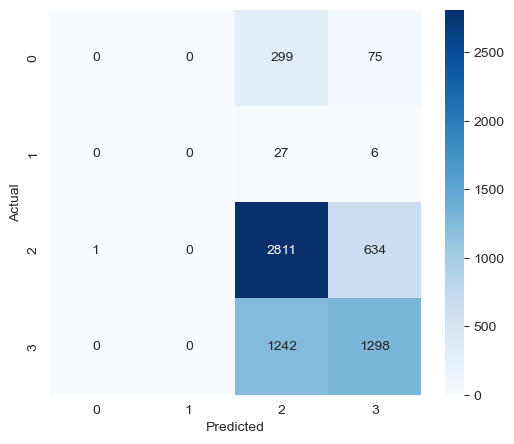

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcul de la matrice de confusion
cm = confusion_matrix(y_valid_encoded, prediction)

# heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Enregristrement du modèle

In [18]:
# Importation des librairies
import pickle

In [19]:
# Enregistrement du modèle
pickle.dump(ideal_model_rf, open('ideal_model_rf.pkl', 'wb'))